In [1]:
from utils import find_corners, stereo_calibration, \
                rmse_2D_detection, plot_rmse_dist, \
                undistort_rectify_save, \
                quaternion_to_transformation, calculate_BF_to_EN, \
                estimate_transform_average, rmse_2D_transform, rmse_3D_disp_plot
from natsort import natsorted
import numpy as np
import pandas as pd
import os, cv2

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Loading Files
LEFT_PATH = "C:\\Users\\f007wsq\\Desktop\\datasets\\davinci_Xi_05282025\\XI_BIGDATA\\calibration_images\\cam1_cropped"
RIGHT_PATH = "C:\\Users\\f007wsq\\Desktop\\datasets\\davinci_Xi_05282025\\XI_BIGDATA\\calibration_images\\cam2_cropped"

LEFT_FILES = os.listdir(LEFT_PATH)
RIGHT_FILES = os.listdir(RIGHT_PATH)

IMG_SIZE = (894, 714)

In [4]:
# Loading and Loading Images by Downsampling
LEFT_IMGS = []
for filename in LEFT_FILES:
    if filename.endswith(".png"):
        LEFT_IMGS.append(filename)
LEFT_IMGS = natsorted(LEFT_IMGS)
LEFT_IMGS = LEFT_IMGS[::4]
print(LEFT_IMGS)

RIGHT_IMGS = []
for filename in RIGHT_FILES:
    if filename.endswith(".png"):
        RIGHT_IMGS.append(filename)
RIGHT_IMGS = natsorted(RIGHT_IMGS)
RIGHT_IMGS = RIGHT_IMGS[::4]
print(RIGHT_IMGS)

['frame_0.png', 'frame_4.png', 'frame_8.png', 'frame_12.png', 'frame_16.png', 'frame_20.png', 'frame_24.png', 'frame_28.png', 'frame_32.png', 'frame_36.png', 'frame_40.png', 'frame_44.png', 'frame_48.png', 'frame_52.png', 'frame_56.png', 'frame_60.png', 'frame_64.png', 'frame_68.png', 'frame_72.png', 'frame_76.png', 'frame_80.png', 'frame_84.png', 'frame_88.png', 'frame_92.png', 'frame_96.png', 'frame_100.png', 'frame_104.png', 'frame_108.png', 'frame_112.png', 'frame_116.png', 'frame_120.png', 'frame_124.png', 'frame_128.png', 'frame_132.png', 'frame_136.png', 'frame_140.png', 'frame_144.png', 'frame_148.png', 'frame_152.png', 'frame_156.png', 'frame_160.png', 'frame_164.png', 'frame_168.png', 'frame_172.png', 'frame_176.png', 'frame_180.png', 'frame_184.png', 'frame_188.png', 'frame_192.png', 'frame_196.png', 'frame_200.png', 'frame_204.png', 'frame_208.png', 'frame_212.png', 'frame_216.png', 'frame_220.png', 'frame_224.png', 'frame_228.png', 'frame_232.png', 'frame_236.png', 'frame_

In [5]:
# Chess board parameters
chessboard_size = (9, 6) # corners
square_size = 6 # mm
frame_size = (894, 714)

# Termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6)

# Prepare object points, like (0,0,0) (1,0,0) ...(6,5,0)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size

## Step 1 - Filtering Out Bad Corner Detections

In [6]:
# First Round: Check Bad Detected Corners 
imgpoints_L, imgpoints_R, objpoints, success_frames = find_corners(LEFT_PATH, RIGHT_PATH, LEFT_IMGS, RIGHT_IMGS, objp, chessboard_size)

criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6)
flags = 0

stereo_params = stereo_calibration(criteria=criteria_stereo, objpoints=objpoints, 
                                   imgpoints_L=imgpoints_L, imgpoints_R=imgpoints_R,
                                   K_L=None, D_L=None, K_R=None, D_R=None, 
                                   img_size=IMG_SIZE, flags=flags)

In [7]:
# Extract stereo parameters
K_L = stereo_params['K_L']
D_L = stereo_params['D_L']
K_R = stereo_params['K_R']
D_R = stereo_params['D_R']

# Calculate RMSE for all successfully detected frames
all_rmse_px_L, all_rmse_mm_L, dist_L, = rmse_2D_detection(objpoints, imgpoints_L, K_L, D_L)
all_rmse_px_R, all_rmse_mm_R, dist_R = rmse_2D_detection(objpoints, imgpoints_R, K_R, D_R)

In [8]:
print( "total pixel error left: {}".format(np.mean(all_rmse_px_L)) )
print( "total pixel error right: {}".format(np.mean(all_rmse_px_R)) )

print( "total mm error left: {}".format(np.mean(all_rmse_mm_L)) )
print( "total mm error right: {}".format(np.mean(all_rmse_mm_R)) )

total pixel error left: 0.30140209197998047
total pixel error right: 0.20159758627414703
total mm error left: 0.08221614248909123
total mm error right: 0.056475691713959594


In [9]:
# Filtering bad frames based on mm RMSE
# This independently filtered out bad corner detections
threshold_mm_L = np.percentile(all_rmse_mm_L, 95)
threshold_mm_R = np.percentile(all_rmse_mm_R, 95)
threshold_px_L = np.percentile(all_rmse_px_L, 95)
threshold_px_R = np.percentile(all_rmse_px_R, 95)
# threshold_mm_L = 0.1
# threshold_mm_R = 0.1
# threshold_px_L = 0.4
# threshold_px_R = 0.4

bad_idx_mm_L = [i for i, err in enumerate(all_rmse_mm_L) if err > threshold_mm_L]
bad_idx_mm_R = [i for i, err in enumerate(all_rmse_mm_R) if err > threshold_mm_R]
bad_idx_px_L = [i for i, err in enumerate(all_rmse_px_L) if err > threshold_px_L]
bad_idx_px_R = [i for i, err in enumerate(all_rmse_px_R) if err > threshold_px_R]


bad_idx = sorted(set(bad_idx_mm_L) | set(bad_idx_mm_R) | set(bad_idx_px_L) | set(bad_idx_px_R))
bad_detect_frames = [success_frames[i] for i in bad_idx]

good_idx = [i for i in range(len(success_frames)) if i not in bad_idx]
good_detect_frames = [success_frames[i] for i in good_idx]

In [10]:
print("threshold_px_L: {}, threshold_px_R: {}".format(threshold_px_L, threshold_px_R))

threshold_px_L: 0.7843837738037109, threshold_px_R: 0.43767979741096497


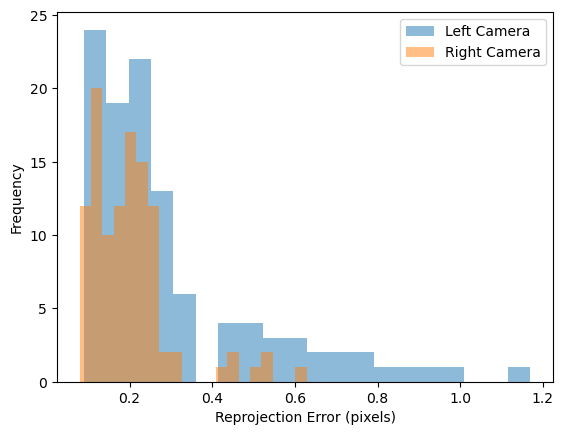

In [11]:
import matplotlib.pyplot as plt
plt.hist(all_rmse_px_L, bins=20, alpha=0.5, label='Left Camera')
plt.hist(all_rmse_px_R, bins=20, alpha=0.5, label='Right Camera')
plt.xlabel('Reprojection Error (pixels)')
plt.ylabel('Frequency')
plt.legend()

In [12]:
print("threshold_mm_L: {}, threshold_mm_R: {}".format(threshold_mm_L, threshold_mm_R))

threshold_mm_L: 0.1747073084380412, threshold_mm_R: 0.0801688752961405


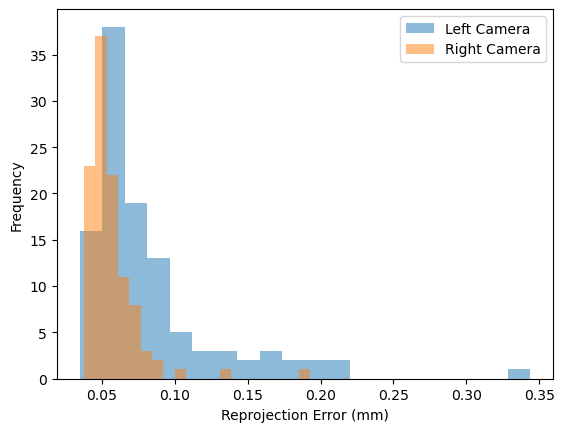

In [13]:
plt.hist(all_rmse_mm_L, bins=20, alpha=0.5, label='Left Camera')
plt.hist(all_rmse_mm_R, bins=20, alpha=0.5, label='Right Camera')
plt.xlabel('Reprojection Error (mm)')
plt.ylabel('Frequency')
plt.legend()

In [14]:
good_detect_L = [pair[0] for pair in good_detect_frames]
good_detect_R = [pair[1] for pair in good_detect_frames]
# These are the frame with GOOD corner detections

In [15]:
print("Number of total frames: ", len(LEFT_IMGS))
print("Number of successful detection frames: ", len(success_frames))
print("Number of good detection frames: ", len(good_detect_frames))

Number of total frames:  133
Number of successful detection frames:  109
Number of good detection frames:  92


## Step 2: Use GOOD Corner Detections to Redo Stereo Calibration

In [16]:
# Redo Stereo Calibration
imgpoints_L, imgpoints_R, objpoints, success_frames = find_corners(LEFT_PATH, RIGHT_PATH, good_detect_L, good_detect_R, objp, chessboard_size)

criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
flags = 0

# Calculating new stereo parameters from GOOD frames only
stereo_params = stereo_calibration(criteria=criteria_stereo, objpoints=objpoints, 
                                   imgpoints_L=imgpoints_L, imgpoints_R=imgpoints_R,
                                   K_L=None, D_L=None, K_R=None, D_R=None, 
                                   img_size=IMG_SIZE, flags=flags)

In [17]:
# This is the final stereo parameters after filtering bad detection frames
K_L = stereo_params['K_L']
D_L = stereo_params['D_L']
K_R = stereo_params['K_R']
D_R = stereo_params['D_R']

all_rmse_px_L, all_rmse_mm_L, dist_L, = rmse_2D_detection(objpoints, imgpoints_L, K_L, D_L)
all_rmse_px_R, all_rmse_mm_R, dist_R = rmse_2D_detection(objpoints, imgpoints_R, K_R, D_R)

In [18]:
print( "total pixel error left: {}".format(np.mean(all_rmse_px_L)) )
print( "total pixel error right: {}".format(np.mean(all_rmse_px_R)) )

print( "total mm error left: {}".format(np.mean(all_rmse_mm_L)) )
print( "total mm error right: {}".format(np.mean(all_rmse_mm_R)) )

total pixel error left: 0.2396438866853714
total pixel error right: 0.17685376107692719
total mm error left: 0.07090586104691349
total mm error right: 0.052890198687219184


In [19]:
print("Round 2 - Number of good detection frames from Round 1:", len(good_detect_frames))
print("Round 2 - Number of successful frames for calibration:", len(success_frames))

Round 2 - Number of good detection frames from Round 1: 92
Round 2 - Number of successful frames for calibration: 92


In [20]:
# Calculate Undistortion and Rectification Remapping
R_L = stereo_params['R_L']
R_R = stereo_params['R_R']
P_L = stereo_params['P_L']
P_R = stereo_params['P_R']

mapL1, mapL2 = cv2.initUndistortRectifyMap(K_L, D_L, R_L, P_L, IMG_SIZE, cv2.CV_16SC2)
mapR1, mapR2 = cv2.initUndistortRectifyMap(K_R, D_R, R_R, P_R, IMG_SIZE, cv2.CV_16SC2)

In [21]:
# Applying Mapping to all images and saving them
save_dir_L = os.path.join(os.path.dirname(LEFT_PATH), 'cam1_rect')
save_dir_R = os.path.join(os.path.dirname(RIGHT_PATH), 'cam2_rect')

os.makedirs(save_dir_L, exist_ok=True)
os.makedirs(save_dir_R, exist_ok=True)

for frame_name_L, frame_name_R in zip(good_detect_L, good_detect_R):
    # Read and undistort left image
    imgL = cv2.imread(os.path.join(LEFT_PATH, frame_name_L))
    save_path_L = os.path.join(save_dir_L, frame_name_L)
    undistort_rectify_save(imgL, save_path_L, mapL1, mapL2)

    # Read and undistort right image
    imgR = cv2.imread(os.path.join(RIGHT_PATH, frame_name_R))
    save_path_R = os.path.join(save_dir_R, frame_name_R)
    undistort_rectify_save(imgR, save_path_R, mapR1, mapR2)

## Step 3 - Filtering Out Bad Tracking Frames

In [22]:
# Detecting Corners in Rectified and Undistorted Images
# Rectified paths
RECT_LEFT_PATH = os.path.join(os.path.dirname(LEFT_PATH), 'cam1_rect')
RECT_RIGHT_PATH = os.path.join(os.path.dirname(RIGHT_PATH), 'cam2_rect')

imgpoints_L, imgpoints_R, objpoints, success_frames = find_corners(RECT_LEFT_PATH, RECT_RIGHT_PATH, good_detect_L, good_detect_R, objp, chessboard_size)

criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
# Force Distortion Coefficients to Zeros for Rectified Images
flags = (cv2.CALIB_FIX_K1 +
         cv2.CALIB_FIX_K2 +
         cv2.CALIB_FIX_K3 +
         cv2.CALIB_FIX_K4 +
         cv2.CALIB_FIX_K5 +
         cv2.CALIB_FIX_K6 +
         cv2.CALIB_ZERO_TANGENT_DIST) 

# stereo_params = stereo_calibration(criteria=criteria_stereo, objpoints=objpoints, 
#                                    imgpoints_L=imgpoints_L, imgpoints_R=imgpoints_R,
#                                    K_L=None, D_L=None, K_R=None, D_R=None, 
#                                    img_size=IMG_SIZE, flags=flags)

In [23]:
success_frames_L = [pair[0] for pair in success_frames]
success_frames_R = [pair[1] for pair in success_frames]

In [24]:
# Extract stereo parameters for rectified images
P_L = stereo_params['P_L'][:3, :3]
D_L = stereo_params['D_L']
P_R = stereo_params['P_R'][:3, :3]
D_R = stereo_params['D_R']

all_rmse_px_L, all_rmse_mm_L, dist_L, = rmse_2D_detection(objpoints, imgpoints_L, P_L, D_L)
all_rmse_px_R, all_rmse_mm_R, dist_R = rmse_2D_detection(objpoints, imgpoints_R, P_R, D_R)

In [25]:
# Calculate BF_to_ENs
# Load transformations collected by Polaris
OT_PATH = os.path.dirname(LEFT_PATH) + "\\transforms.csv"
OT_READINGS = pd.read_csv(OT_PATH)

# Define TF from CPcb to CPot
# CPcb: calibration plate checkerboard frame (origin at the top-left corner)
# CPot: calibration plate optical frame by ROM file (origin at the center of a sphere)
CPcb_to_CPot = np.array([[ 0,  1, 0, 54],
                          [ 1,  0, 0, 36],
                          [ 0,  0, -1, -8.132],
                          [ 0,  0, 0, 1]])

BF_to_EN_L_list, CPcb_to_EN_L_list, EN_to_CPcb_L_list, BF_to_CPcb_list = calculate_BF_to_EN(OT_READINGS, 
                                                                                            objpoints,
                                                                                            imgpoints_L,
                                                                                            success_frames_L,
                                                                                            CPcb_to_CPot,
                                                                                            P_L, D_L)

BF_to_EN_R_list, CPcb_to_EN_R_list, EN_to_CPcb_R_list, BF_to_CPcb_list = calculate_BF_to_EN(OT_READINGS, 
                                                                                            objpoints,
                                                                                            imgpoints_R,
                                                                                            success_frames_R,
                                                                                            CPcb_to_CPot,
                                                                                            P_R, D_R)

BF_to_EN_L_svd = estimate_transform_average(BF_to_CPcb_list, CPcb_to_EN_L_list)
BF_to_EN_L_avg = np.mean(np.array(BF_to_EN_L_list), axis=0)
BF_to_EN_L_std = np.std(np.array(BF_to_EN_L_list), axis=0)

BF_to_EN_R_svd = estimate_transform_average(BF_to_CPcb_list, CPcb_to_EN_R_list)
BF_to_EN_R_avg = np.mean(np.array(BF_to_EN_R_list), axis=0)
BF_to_EN_R_std = np.std(np.array(BF_to_EN_R_list), axis=0)


print(BF_to_EN_L_std)
print(BF_to_EN_R_std)

[[3.42668351e-03 7.81609468e-03 1.72712884e-02 4.90757413e+00]
 [1.68700544e-02 1.46346292e-02 4.09125687e-04 1.79630128e+00]
 [7.88646425e-03 3.47028531e-03 1.41527605e-02 4.27030629e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[3.45756758e-03 7.86701986e-03 1.72942294e-02 5.04546140e+00]
 [1.64823787e-02 1.52565252e-02 4.49817166e-04 1.70969650e+00]
 [7.95710834e-03 3.49486827e-03 1.43235519e-02 4.27526780e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [26]:
all_rmse_px_L, all_rmse_mm_L, dist_L = rmse_2D_transform(OT_READINGS,
                                                         objp,
                                                         objpoints,
                                                         imgpoints_L,
                                                         chessboard_size,
                                                         RECT_LEFT_PATH,
                                                         success_frames_L,
                                                         CPcb_to_CPot,
                                                         BF_to_EN_L_svd,
                                                         P_L, D_L)

all_rmse_px_R, all_rmse_mm_R, dist_R = rmse_2D_transform(OT_READINGS,
                                                         objp,
                                                         objpoints,
                                                         imgpoints_R,
                                                         chessboard_size,
                                                         RECT_RIGHT_PATH,
                                                         success_frames_R,
                                                         CPcb_to_CPot,
                                                         BF_to_EN_R_svd,
                                                         P_R, D_R)


print( "total pixel error left: {}".format(np.mean(all_rmse_px_L)) )
print( "total pixel error right: {}".format(np.mean(all_rmse_px_R)) )

print( "total mm error left: {}".format(np.mean(all_rmse_mm_L)) )
print( "total mm error right: {}".format(np.mean(all_rmse_mm_R)) )

total pixel error left: 4.176063537597656
total pixel error right: 4.036285400390625
total mm error left: 1.1333261196715276
total mm error right: 1.0962655058223303


In [27]:
from utils import rmse_3D_transform_plot
all_rmse_3D_transform_L= rmse_3D_transform_plot(OT_READINGS,
                                            objpoints,
                                            imgpoints_L,
                                            LEFT_PATH,
                                            success_frames_L,
                                            CPcb_to_CPot,
                                            BF_to_EN_L_svd,
                                            P_L, D_L, plot=False)
all_rmse_3D_transform_R= rmse_3D_transform_plot(OT_READINGS,
                                            objpoints,
                                            imgpoints_R,
                                            RIGHT_PATH,
                                            success_frames_R,      
                                            CPcb_to_CPot,
                                            BF_to_EN_R_svd,
                                            P_R, D_R, plot=False)

c:\Users\f007wsq\Documents\GitHub\StereoReconstruction\Calibration\utils.py:520: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


total 3D mm error left: 3.6757240435064613


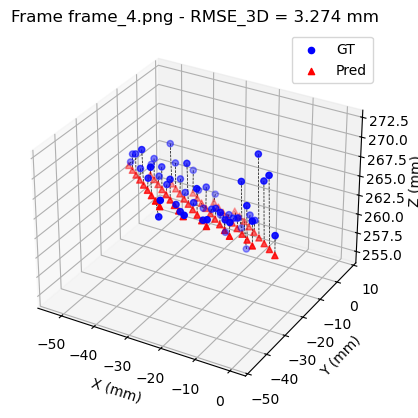

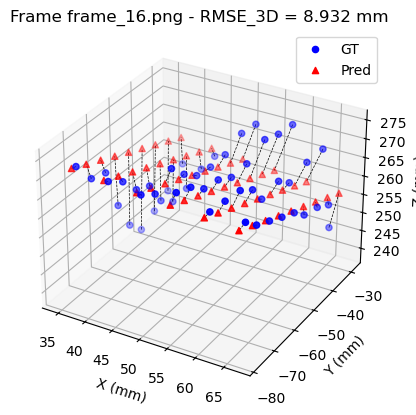

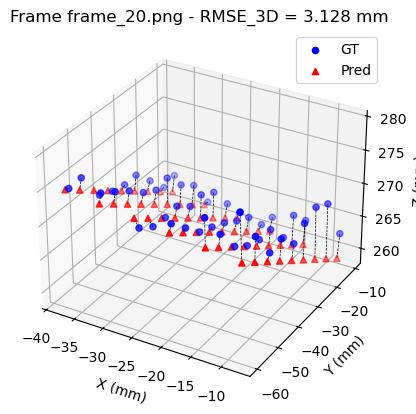

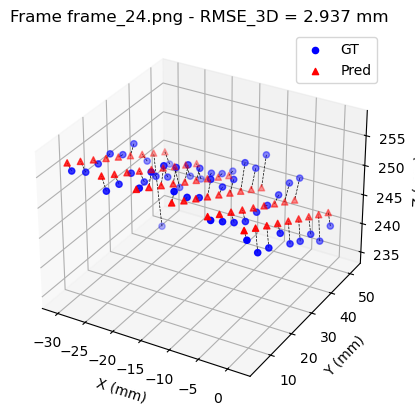

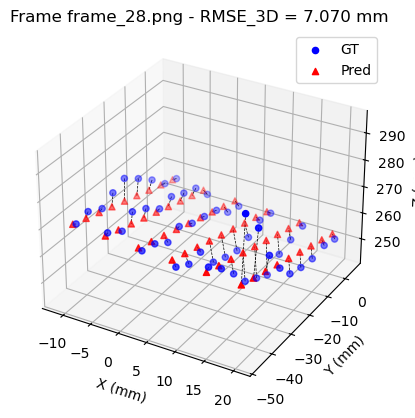

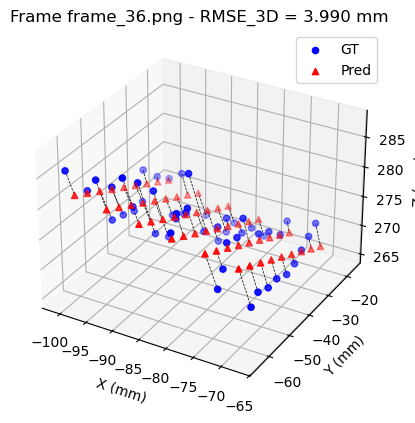

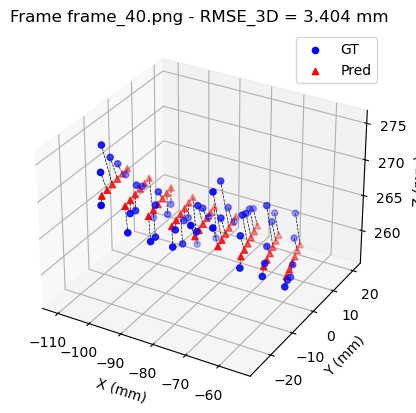

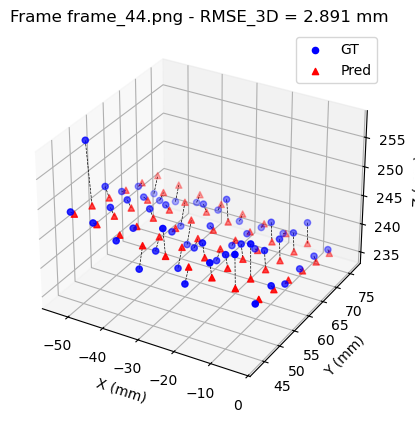

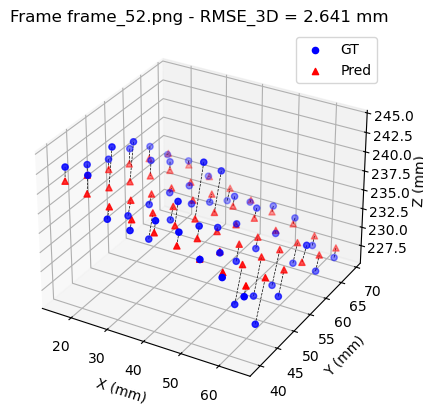

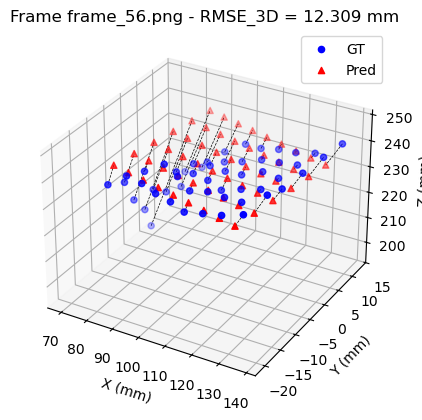

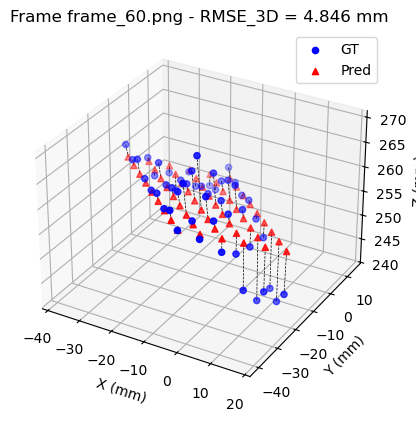

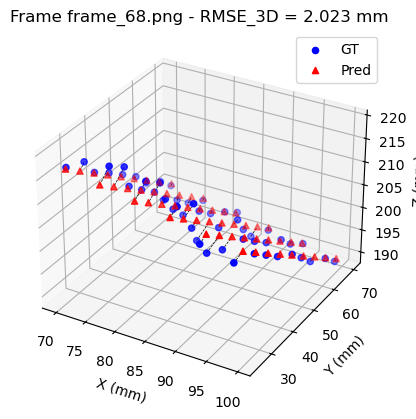

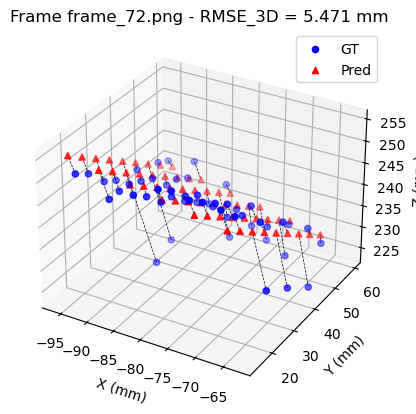

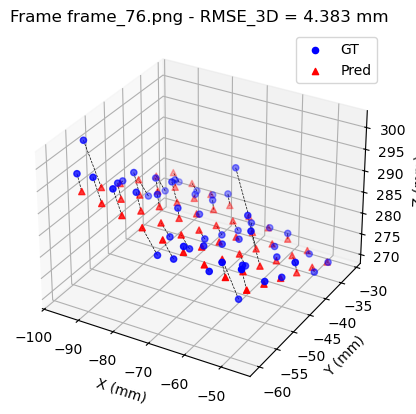

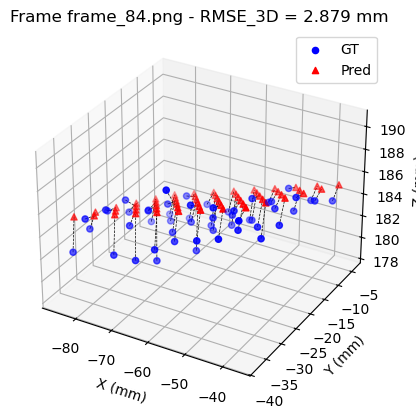

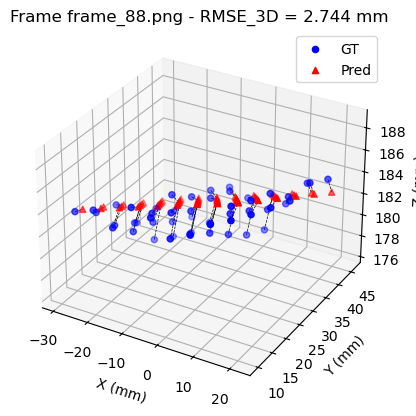

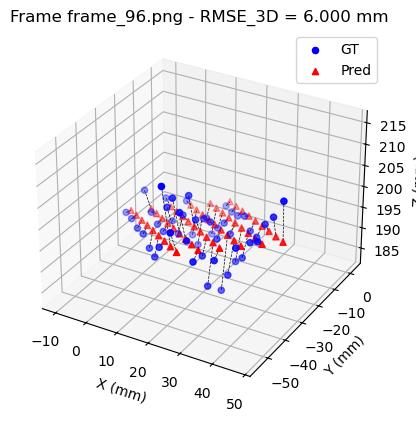

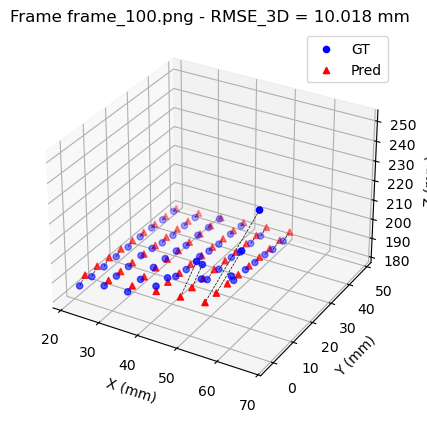

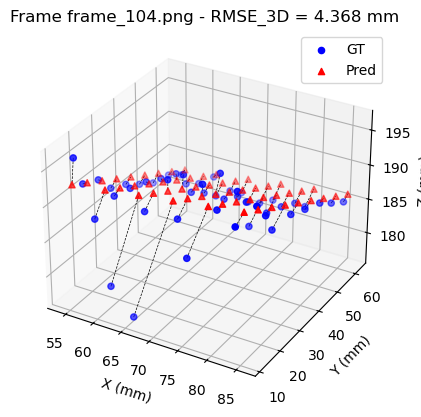

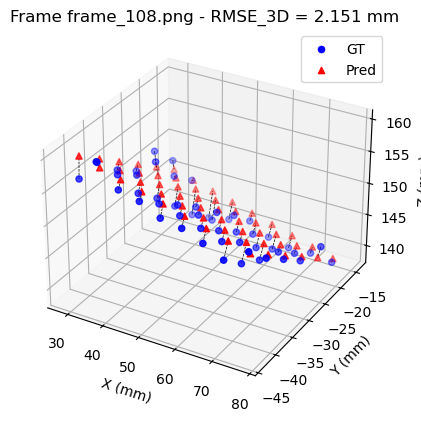

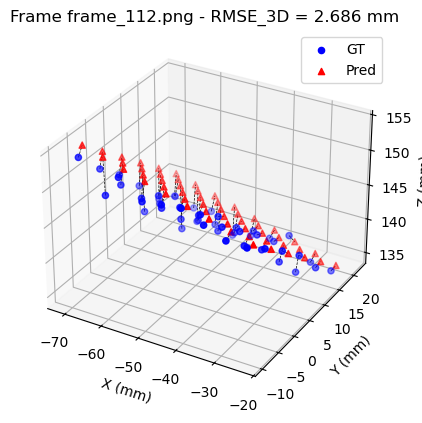

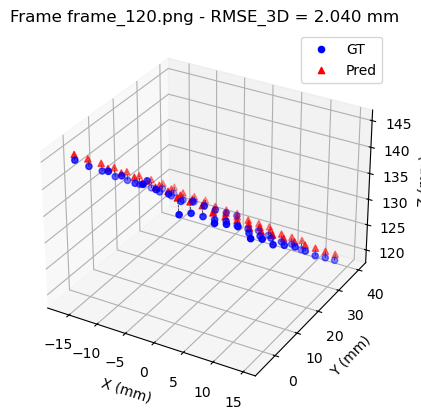

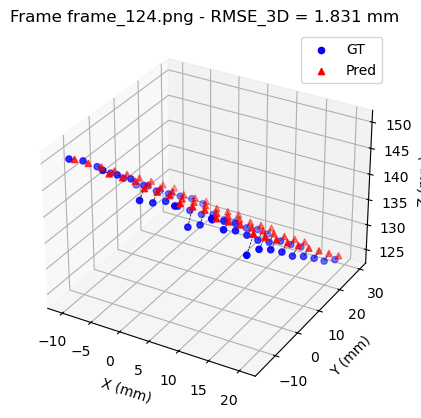

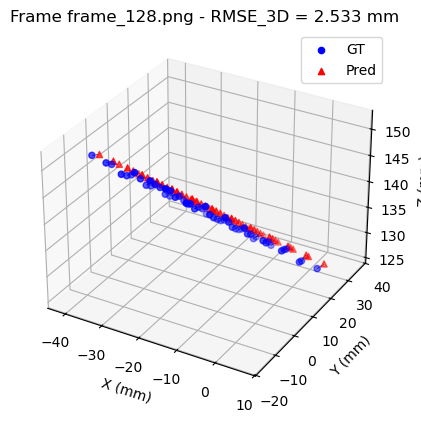

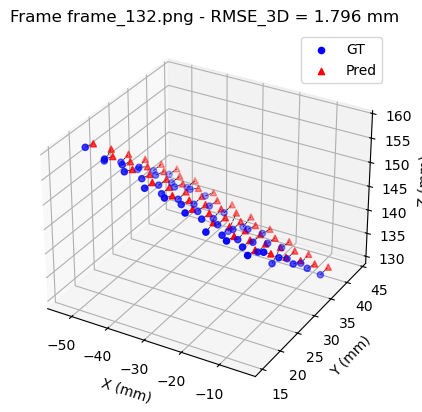

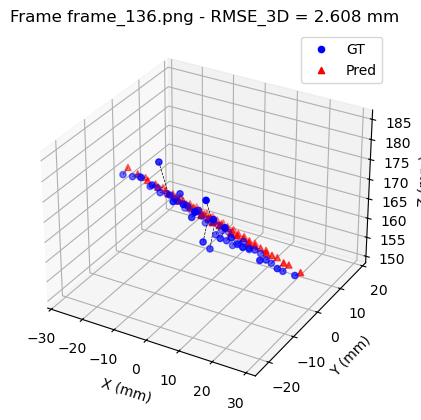

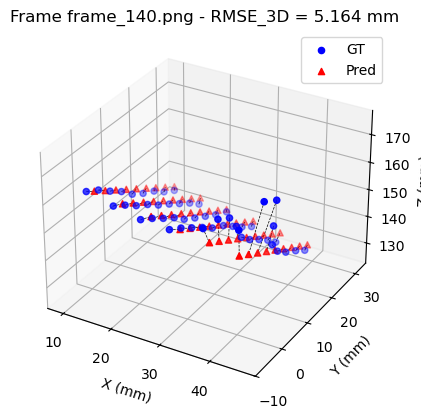

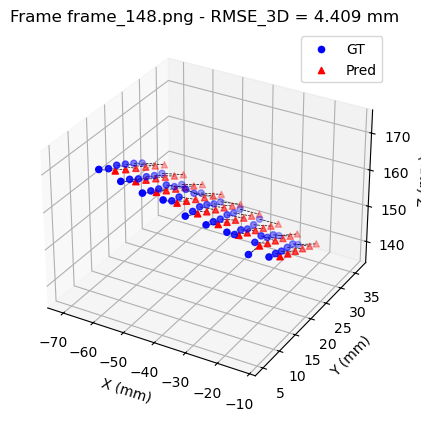

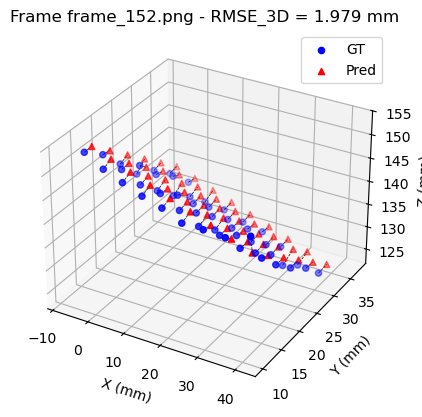

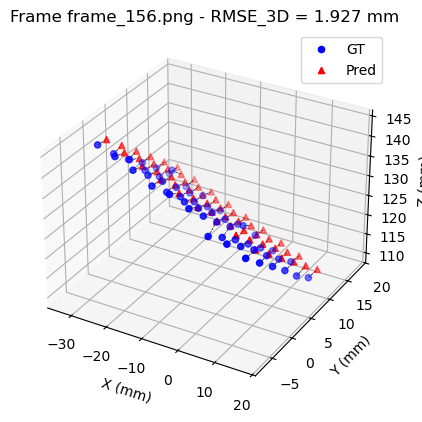

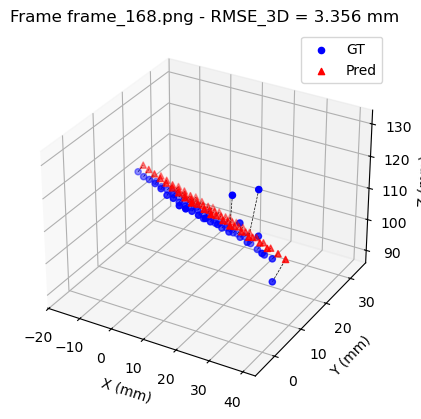

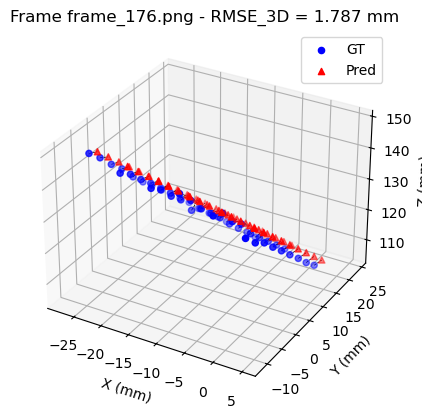

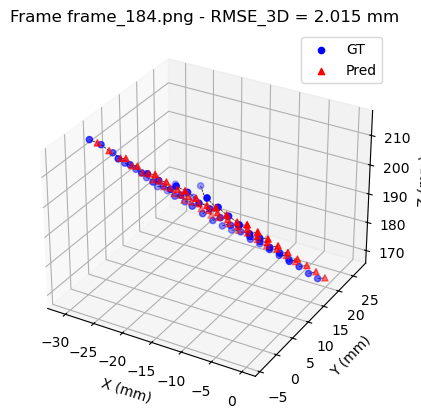

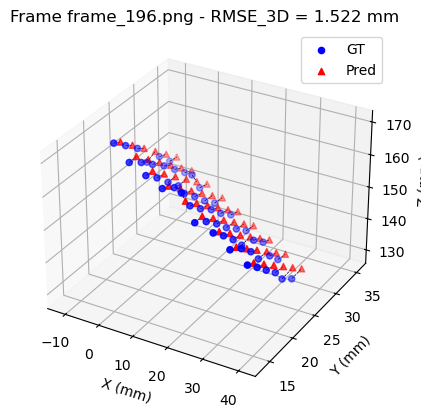

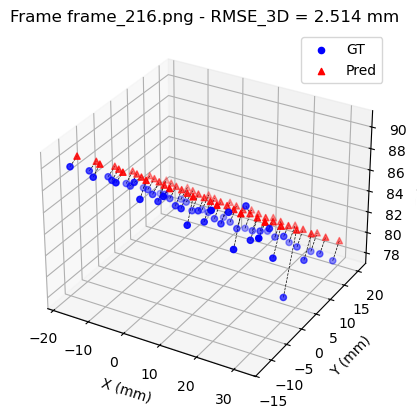

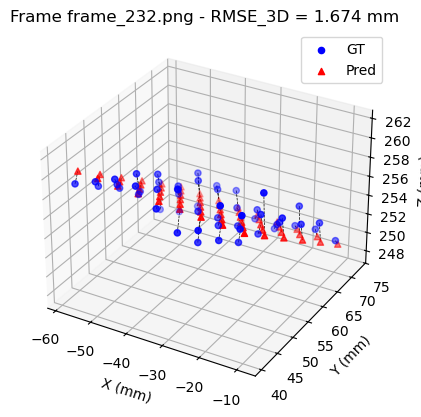

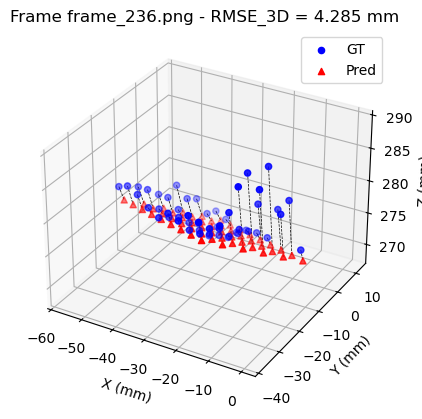

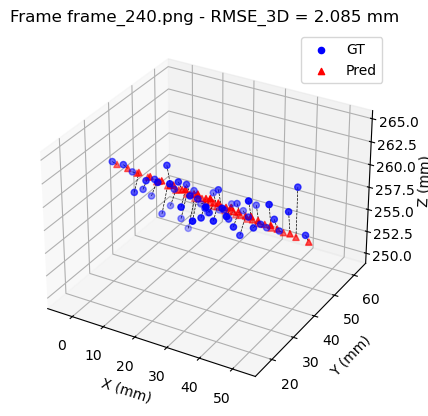

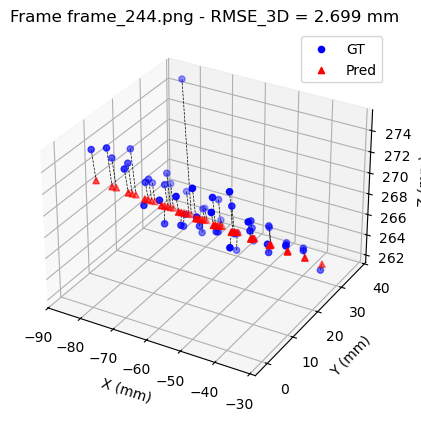

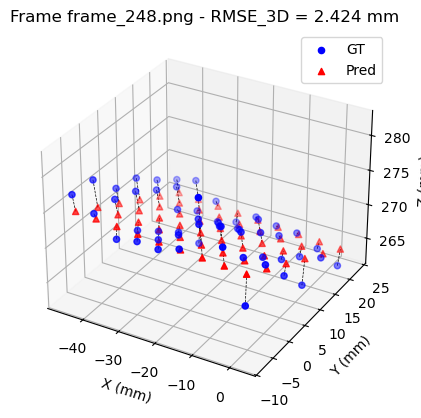

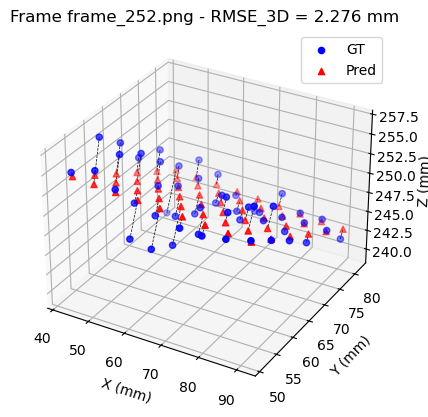

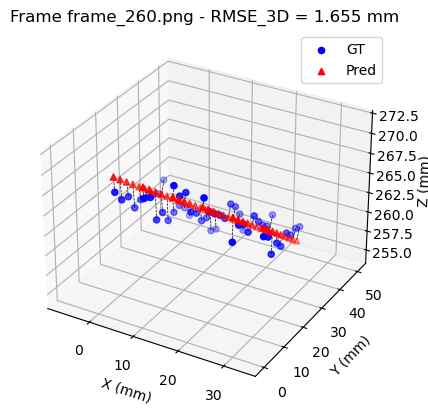

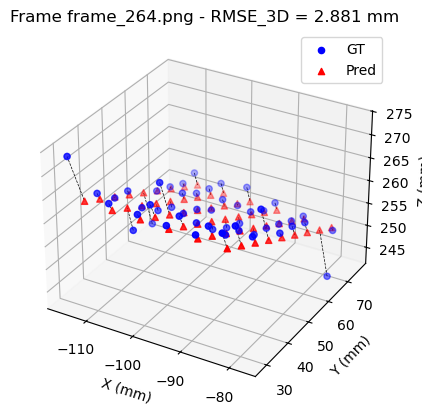

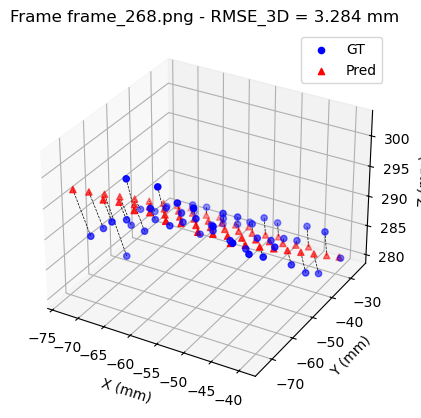

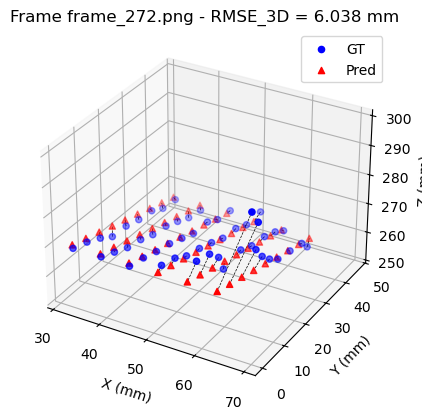

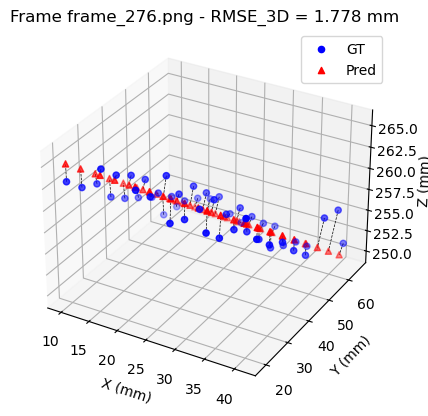

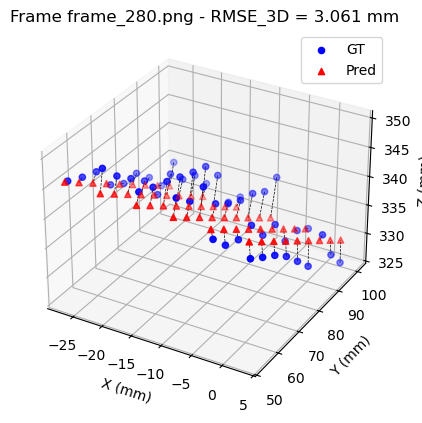

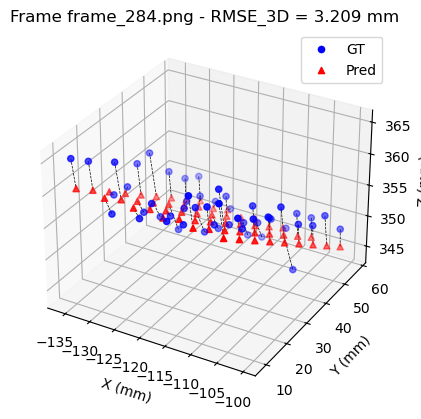

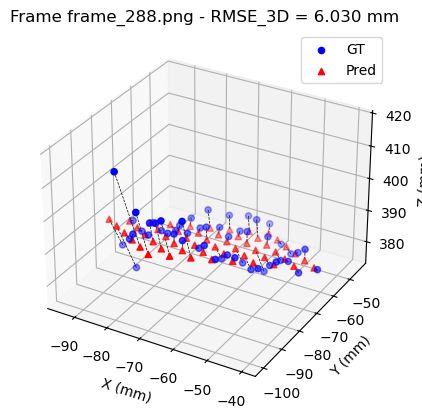

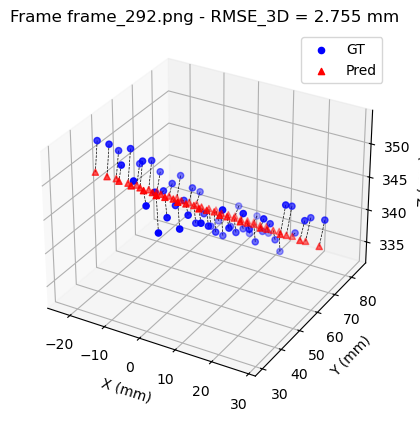

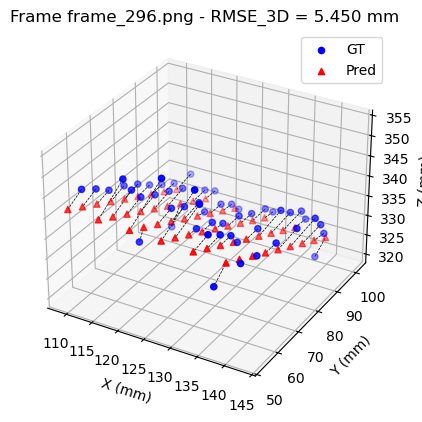

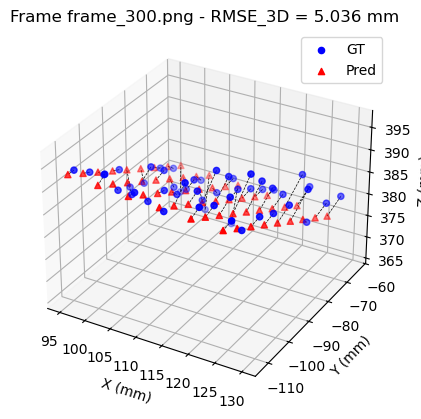

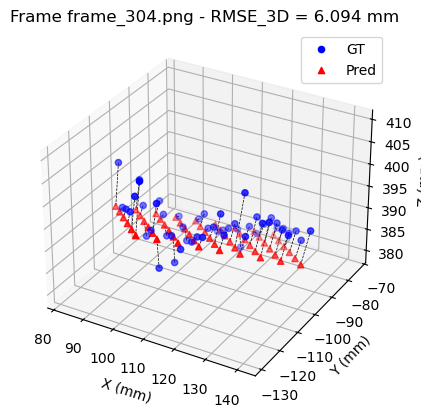

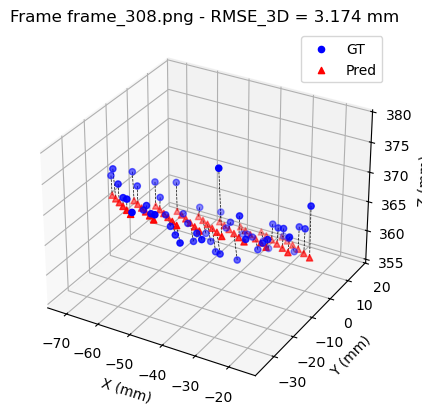

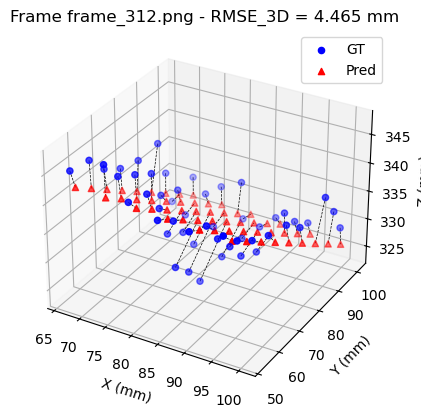

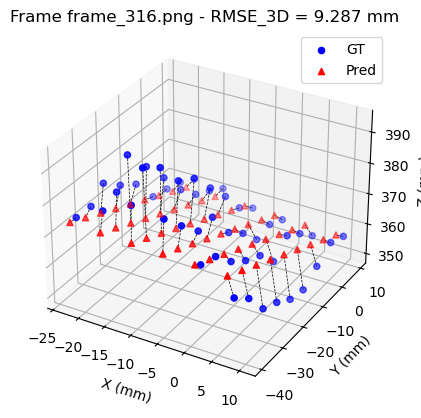

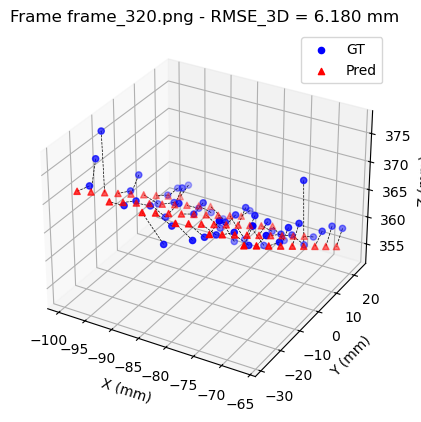

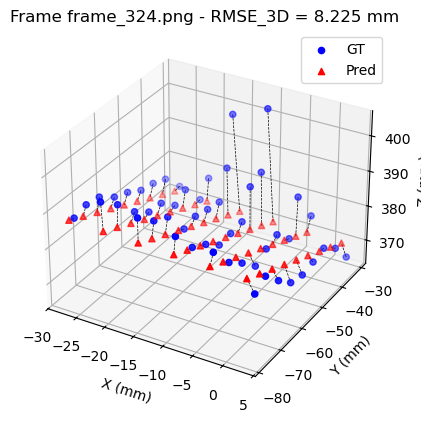

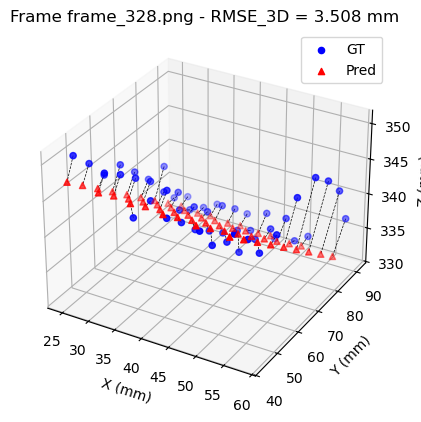

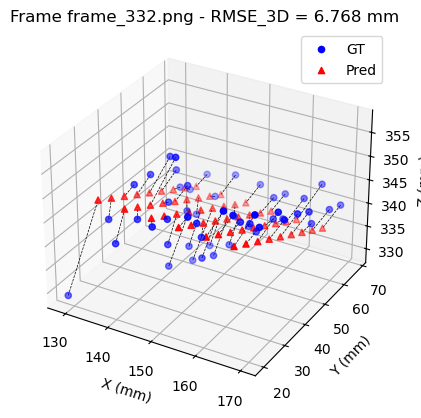

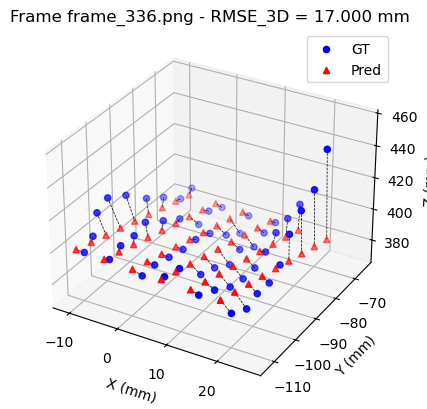

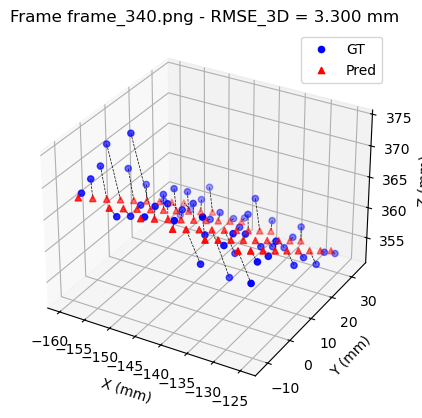

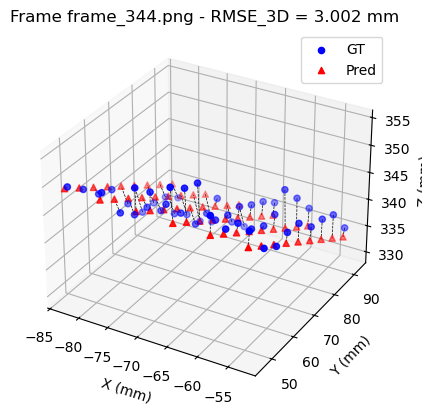

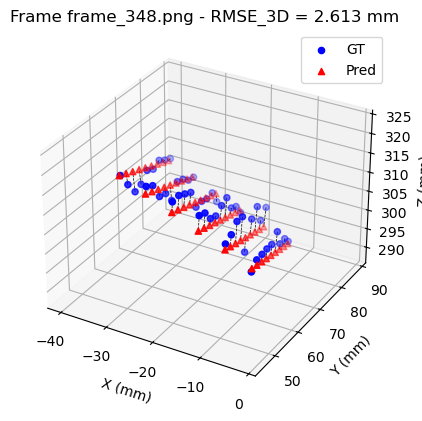

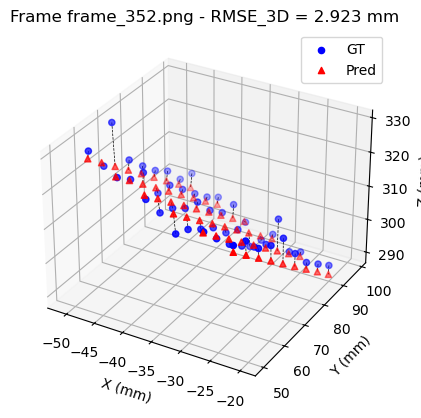

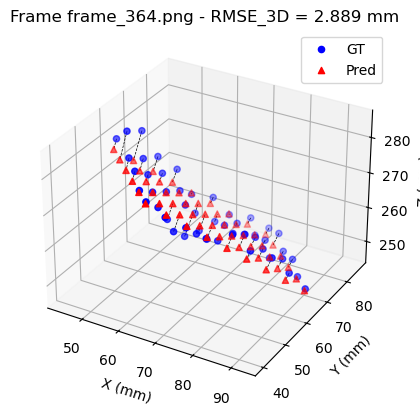

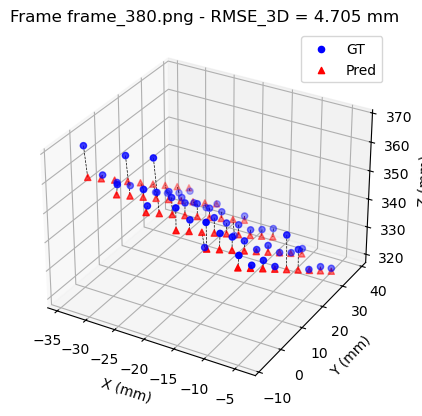

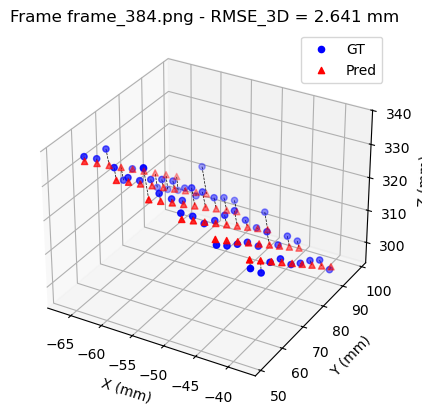

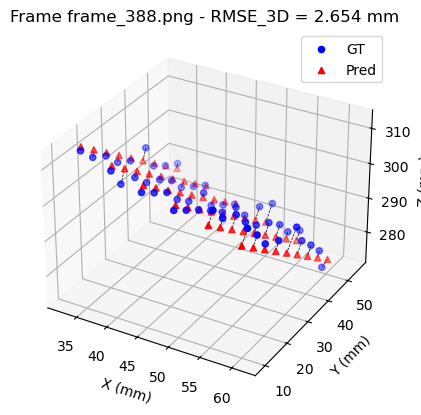

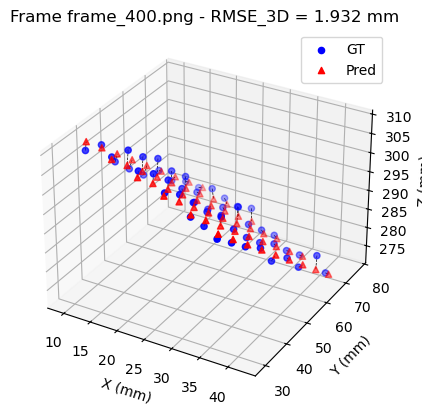

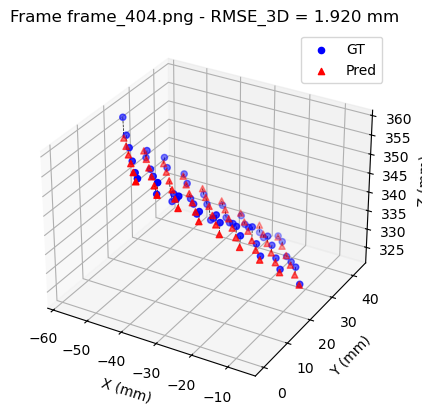

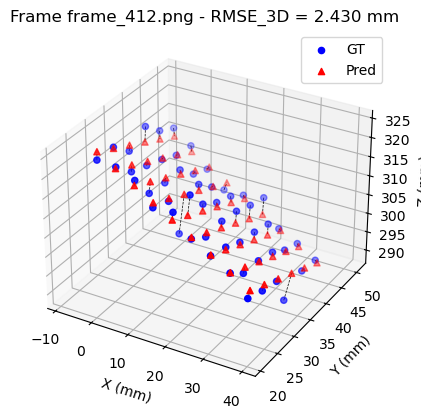

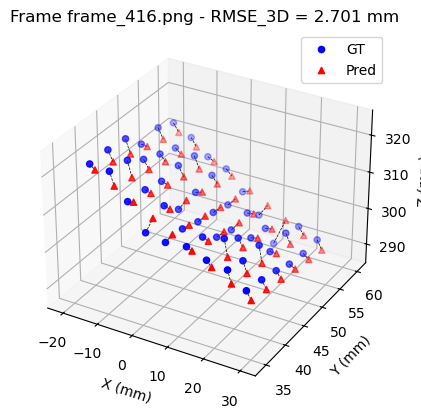

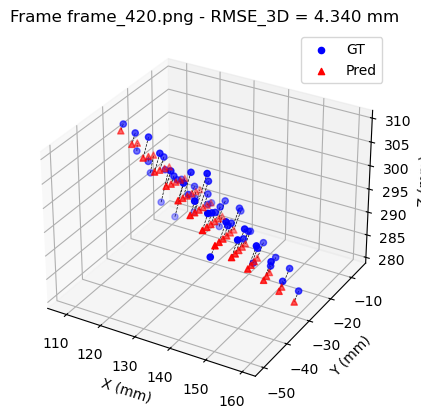

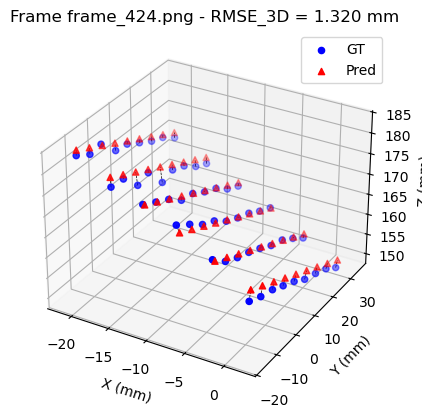

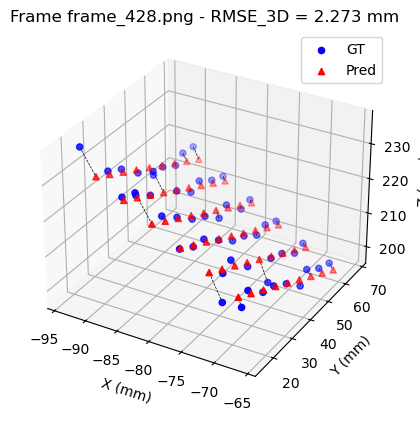

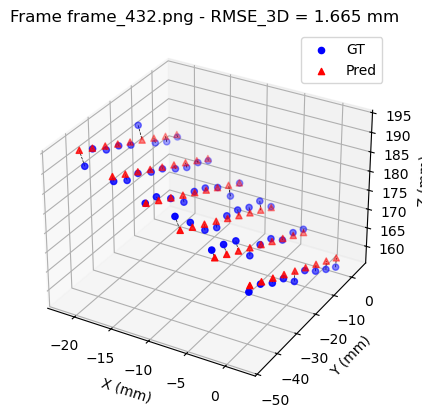

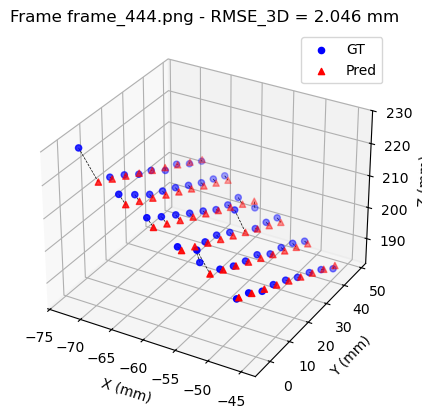

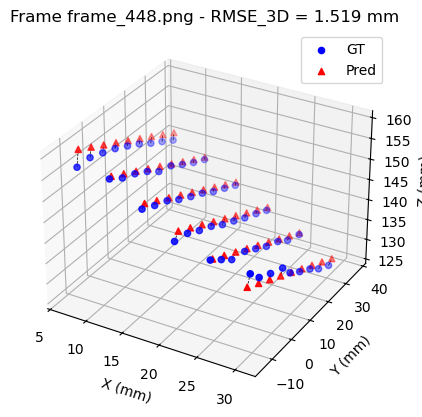

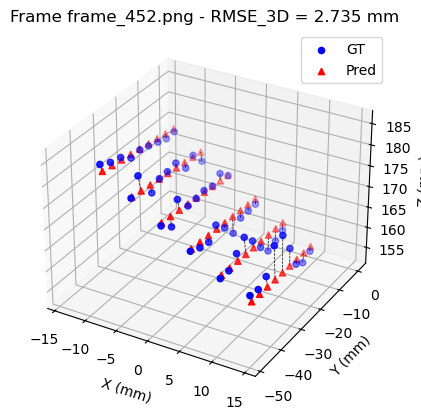

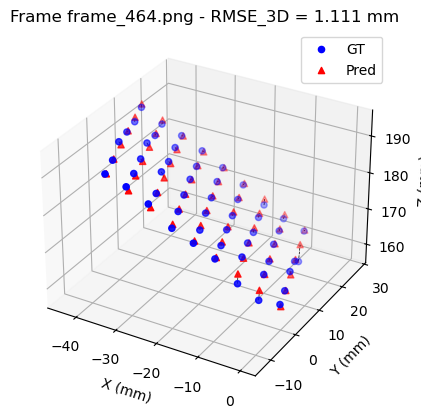

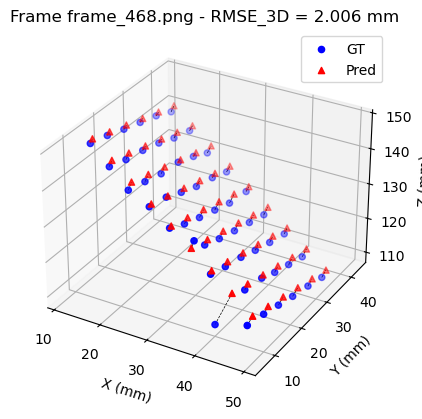

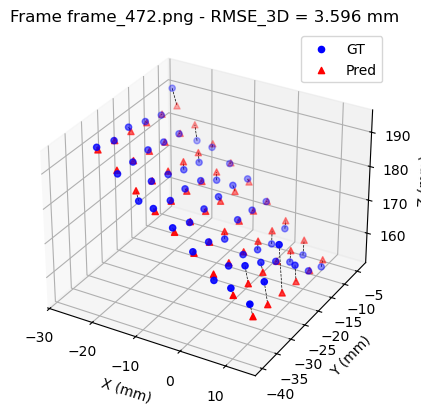

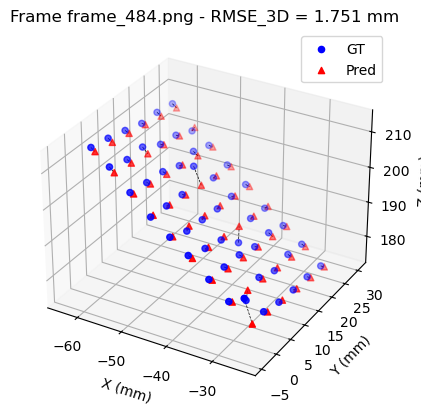

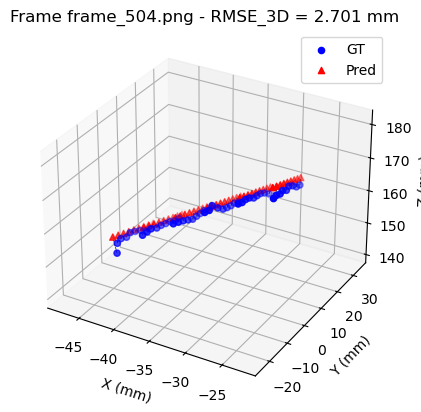

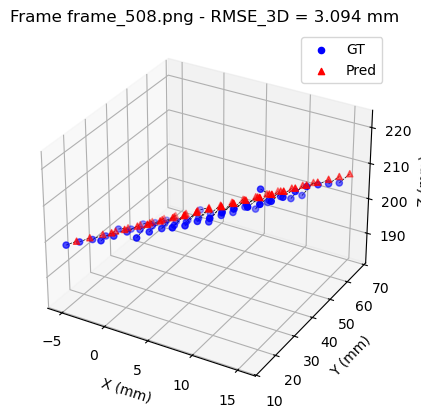

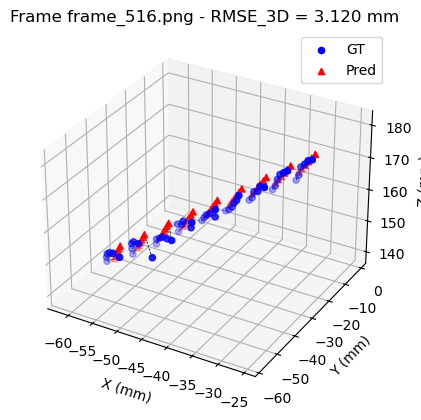

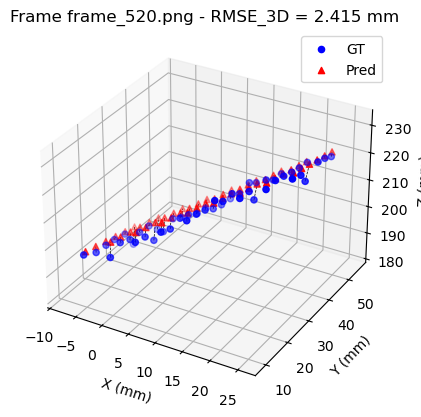

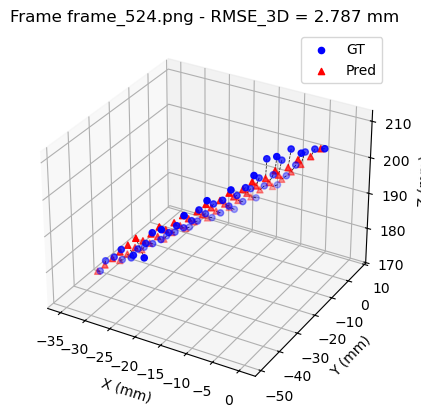

In [28]:
all_rmse_3D_disp= rmse_3D_disp_plot(OT_READINGS,
                                            objpoints,
                                            imgpoints_L,
                                            imgpoints_R,
                                            LEFT_PATH,
                                            success_frames_L,
                                            CPcb_to_CPot,
                                            BF_to_EN_L_svd,
                                            stereo_params)

print( "total 3D mm error left: {}".format(np.mean(all_rmse_3D_disp)) )

In [29]:
print("3D mm error (transform): left {}, right {}".format(np.mean(all_rmse_3D_transform_L), np.mean(all_rmse_3D_transform_R)))
print("3D mm error (disparity): {}".format(np.mean(all_rmse_3D_disp)))

3D mm error (transform): left 1.6940029321171024, right 1.70411732585449
3D mm error (disparity): 3.6757240435064613


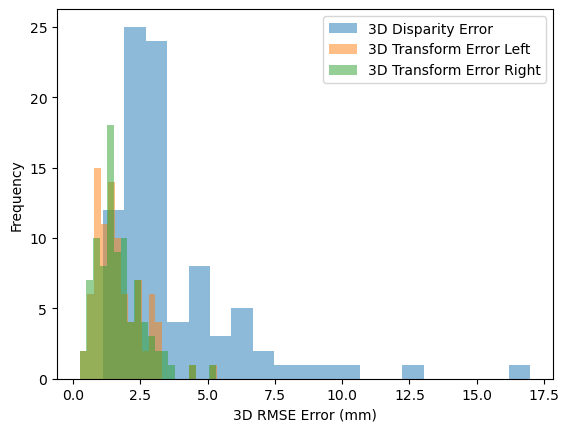

In [30]:
plt.hist(all_rmse_3D_disp, bins=20, alpha=0.5, label='3D Disparity Error')
plt.hist(all_rmse_3D_transform_L, bins=20, alpha=0.5, label='3D Transform Error Left')
plt.hist(all_rmse_3D_transform_R, bins=20, alpha=0.5, label='3D Transform Error Right')
plt.xlabel('3D RMSE Error (mm)')        
plt.ylabel('Frequency')
plt.legend()

In [34]:
# filter out frames with high 3D error (greater than 1mm)
threshold = np.percentile(all_rmse_3D_disp, 95)

good_3D_idx = [i for i, err in enumerate(all_rmse_3D_disp) if err <= threshold]
good_frames_L = [success_frames_L[i] for i in good_3D_idx]
good_frames_R = [success_frames_R[i] for i in good_3D_idx]

In [35]:
with open(os.path.join(os.getcwd(), 'good_frames_L.txt'), 'w') as f:
    for frame in good_frames_L:
        f.write(frame + '\n')

with open(os.path.join(os.getcwd(), 'good_frames_R.txt'), 'w') as f:
    for frame in good_frames_R:
        f.write(frame + '\n')

In [36]:
good_frames_L


['frame_4.png',
 'frame_20.png',
 'frame_24.png',
 'frame_28.png',
 'frame_36.png',
 'frame_40.png',
 'frame_44.png',
 'frame_52.png',
 'frame_60.png',
 'frame_68.png',
 'frame_72.png',
 'frame_76.png',
 'frame_84.png',
 'frame_88.png',
 'frame_96.png',
 'frame_104.png',
 'frame_108.png',
 'frame_112.png',
 'frame_120.png',
 'frame_124.png',
 'frame_128.png',
 'frame_132.png',
 'frame_136.png',
 'frame_140.png',
 'frame_148.png',
 'frame_152.png',
 'frame_156.png',
 'frame_168.png',
 'frame_176.png',
 'frame_184.png',
 'frame_196.png',
 'frame_216.png',
 'frame_232.png',
 'frame_236.png',
 'frame_240.png',
 'frame_244.png',
 'frame_248.png',
 'frame_252.png',
 'frame_260.png',
 'frame_264.png',
 'frame_268.png',
 'frame_272.png',
 'frame_276.png',
 'frame_280.png',
 'frame_284.png',
 'frame_288.png',
 'frame_292.png',
 'frame_296.png',
 'frame_300.png',
 'frame_304.png',
 'frame_308.png',
 'frame_312.png',
 'frame_320.png',
 'frame_324.png',
 'frame_328.png',
 'frame_332.png',
 'frame_